# Co-editors

This page focuses on co-editorship, especially of collected volumes, in the *Bibliographie*.   

In [1]:
# === Imports === 

import re 
import seaborn as sns
from matplotlib import pyplot as plt
from os.path import join, abspath, normpath, realpath
import os
from lxml import etree
from io import StringIO, BytesIO
from collections import Counter
import pandas as pd
import netgraph
import numpy as np
from IPython.display import HTML, display   
import networkx as nx
from pyvis.network import Network 
import matplotlib.pyplot as plt


# === Namespaces === 

namespaces = {
    "foaf" : "http://xmlns.com/foaf/0.1/",
    "bib" : "http://purl.org/net/biblio#",
    "dc" : "http://purl.org/dc/elements/1.1/",
    "z" : "http://www.zotero.org/namespaces/export#",
    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    }


# === Files and parameters === 

wdir = join("/", "media", "christof", "Data", "Github", "christofs", "BIB18")
bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_2024-01-02.rdf") 
#bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_TEST.rdf") 
#graphviz_file = join(wdir, "figures", "collaboration_coeditors-network.svg") 


# === Load the dataset === 

def read_xml(bibdatafile): 
    bibdata = etree.parse(bibdatafile)
    return bibdata

bibdata = read_xml(bibdatafile)

## Number of collaborators in co-editorship

This section determines how frequent co-editorship is. 

Multiple entries of the same edited volume are taken into account only once, in this iteration of the analysis. (This avoids an undue inflation of the number of cases of co-editorship in cases where multiple chapters from the same edited volume are present in the database.) However, at the moment, this comes at the expense of the edited books not being included in the analysis. These will be added next. 

There are 14421 instances of element 'BookSection'.
All of the book sections mentioned above correspond to (only) 2825 different titles of edited volumes.
This means that, on average, an edited volume is mentioned 5.1 times, each mention corresponding to one section of the volume being mentioned.

The following table shows counts and percentages for different numbers of co-editors.



number,count,percentage
0,352,12.5
1,923,32.7
2,1068,37.8
3,359,12.7
4,101,3.6
5,17,0.6
6,5,0.2



The following visualization shows counts and percentages for different numbers of co-editors.



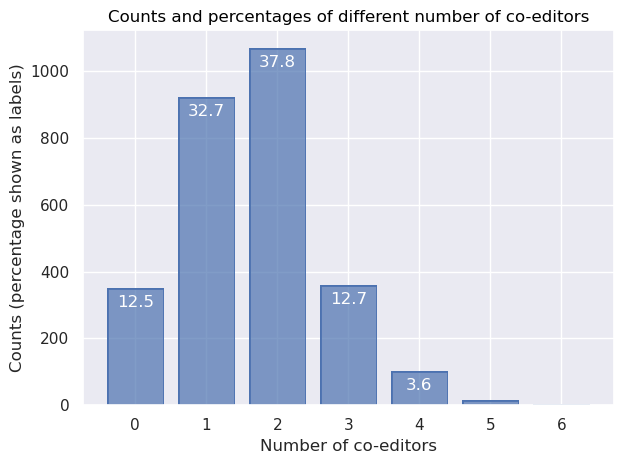

In [8]:
def get_editordata(bibdata): 
    """
    Collects data on the titles and editors of all collected volumes for which the dataset includes book sections (like chapters).
    Simplifies the data to just unique titles of collected volumes with their editors.
    """
    # Find all instances of book chapters or book sections
    xpath = "//bib:BookSection"
    sections = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(sections)) +  " instances of element 'BookSection'.")

    # Also, find all instances of books mentioned as a whole and that have editors. 
    # === TBD ===

    # For each section (and each book), get the editor(s), booktitle, authors, sectiontitle
    editordata = {}
    counter = 0
    for sec in sections[:]: 
        counter +=1
        xpath = ".//bib:editors//foaf:surname//text()"
        editors = sec.xpath(xpath, namespaces=namespaces)
        editors = [editor for editor in editors if "lacollaborationde" not in editor]
        xpath = ".//bib:Book/dc:title//text()"
        try: 
            booktitle = sec.xpath(xpath, namespaces=namespaces)[0]
        except: 
            booktitle = "missing title number " + str(counter)
            #print(booktitle) # Only happens less than 10 times, it seems. 
        # Collect each booktitle only once; only last occurrence is kept (!)
        editordata[booktitle] = editors
    # Check results 
    print("All of the book sections mentioned above correspond to (only)", len(editordata), "different titles of edited volumes.")
    ratio = np.round(np.divide(len(sections), len(editordata)),2)
    print("This means that, on average, an edited volume is mentioned", ratio, "times, each mention corresponding to one section of the volume being mentioned.")

    #for title,editors in editordata.items(): 
    #    print(editors,title)
    return editordata
editordata = get_editordata(bibdata)


def get_coeditor_numbers(editordata): 
    """
    Based on the editordata, establish the number of times each number of co-editors appears, 
    as well as the corresponding percentages for each number of co-editors. 
    """
    coeditors = Counter([len(item) for item in editordata.values()])
    coeditors = pd.DataFrame(pd.Series(coeditors, name="count"))
    coeditors["percentage"] = np.round(np.multiply(np.divide(coeditors["count"], np.sum(coeditors["count"])),100),1)
    # Prettify the DataFrame
    coeditors["number"] = coeditors.index
    coeditors = coeditors.sort_values(by="number")
    coeditors = coeditors[['number', 'count', 'percentage']]
    print("\nThe following table shows counts and percentages for different numbers of co-editors.\n")
    display(HTML(coeditors.to_html(index=False)))
    return coeditors
coeditors = get_coeditor_numbers(editordata)


def visualize_coeditor_numbers(coeditors): 
    """
    Create a simple bar plot that shows 
    the percentage of each number of co-editors in the dataset.
    """
    print("\nThe following visualization shows counts and percentages for different numbers of co-editors.\n")

    import seaborn.objects as so
    (
        so.Plot(data=coeditors, x="number", y="count", text="percentage")
        .add(so.Bar())
        .add(so.Text(color="w", valign="top", offset=5))
        .scale(x=so.Continuous().tick(every=1))
        .label(
            x="Number of co-editors",
            y="Counts (percentage shown as labels)",
            title = "Counts and percentages of different number of co-editors")
        .save("figures/coeditor-percentages.png", dpi=300)
        .show()
    )
visualize_coeditor_numbers(coeditors)


############## Note from January 3, 2024 #############
# Attention! For the moment, this data only looks at the book titles and editors for book sections. 
# However, there are also many "books" with editors (so not monographs), and these need to be taken into account as well.
# What the results show already, compared to the earlier results, is that there is indeed a massive shift visible because of the (correct) aggregation of the editor data to the unique book titles. 
# It will be interesting to see what happens to the co-editorship network, I expect it to shift as well. 
#########################################################


Compared with the data on co-authorship (of books, articles and chapters), the figure above shows that co-editorship works quite differently. Indeed, when looking at editorship (of edited volumes or editions), joint editorship with two editors is the most common case (with around 38% of the cases). Single editorship, however, is also widespread (with 32%) and triple co-editorship not uncommon (at 12.7%). 

It could be interesting to distinguish between editorship of edited volumes on the one hand, and textual editions, on the other hand. This is future work. 

## Coeditor pairs

Looks at which people have frequently collaborated as editors of edited volumes and/or editions. 

In [9]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


def get_recurring_coeditors(editordata): 
    """
    Which people have frequently collaborated as editors? 
    This is based on the data collected above (editors of unique titles). 
    """

    # Define filenames for output. 
    coeditorcounts_top_file = join(wdir, "results", "coeditor-counts_top.csv")
    coeditorcounts_full_file = join(wdir, "results", "coeditor-counts_full.csv")

    # Get editor names from editordata. 
    coeditors = editordata.values()
    print("Overall", len(coeditors), "publications with editors are considered here.")

    # Establish the count of each collaboration between editors
    import itertools 
    all_coeditor_combinations = []
    for item in coeditors: 
        coeditor_combinations = list(itertools.combinations(item, 2))
        coeditor_combinations = [tuple(sorted(item)) for item in coeditor_combinations]
        for coedcomb in coeditor_combinations: 
            all_coeditor_combinations.append(coedcomb)
    ccc = dict(Counter(all_coeditor_combinations)) # ccc = coeditor_combinations_count

    # Transform to a DataFrame
    ccc = pd.DataFrame.from_dict(ccc, orient="index", columns=["count"])
    ccc = ccc.reset_index()
    ccc_split = pd.DataFrame(ccc["index"].tolist())
    ccc_merged = ccc_split.merge(ccc, left_index=True, right_index=True)
    ccc = ccc_merged.drop(["index"], axis=1)
    ccc = ccc.rename({0 : "coeditor1", 1 : "coeditor2"}, axis=1)
    ccc = ccc.sort_values(by="count", ascending=False)
    #print(ccc.head())
    #print(ccc.shape, "shape of dataframe")
    with open(join(coeditorcounts_full_file), "w", encoding="utf8") as outfile: 
        ccc.to_csv(outfile, sep=";")

    # Filter the DataFrame to make it manageable for visualization
    # Determine the top N most frequent co-editors
    coeditors_top = list(set(list(ccc.head(20).loc[:,"coeditor1"]) +\
        list(ccc.head(20).loc[:,"coeditor2"])))
    #print(coeditors_top)
    print("Among all editors, " + str(len(coeditors_top)) + " have been selected as the most active co-editors.")
    # Filter the DataFrame to include just the collaborations involving at least one of the top co-editors. 
    # The resulting DataFrame will have all collaborations between the top co-editors and their co-editors. 
    ccc_filtered = ccc[(ccc["coeditor1"].isin(coeditors_top)) |\
                       (ccc["coeditor2"].isin(coeditors_top))]
    #print(ccc_filtered.shape, "shape of dataframe of top co-editors and their co-editors.")
    # Simplify the labels 
    #ccc_filtered = ccc_filtered.replace(' .*?]', '',regex=True).astype(str)
    ccc_filtered.loc[:,'coeditor1'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor1']]
    ccc_filtered.loc[:,'coeditor2'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor2']]
    
    print("The following table shows the 12 most active pairs of editors.\n")
    from IPython.display import HTML, display   
    display(HTML(ccc_filtered.head(12).to_html(index=False)))

    with open(join(coeditorcounts_top_file), "w", encoding="utf8") as outfile: 
        ccc_filtered.to_csv(outfile, sep=";")
    return ccc_filtered

ccc_filtered = get_recurring_coeditors(editordata)

Overall 2825 publications with editors are considered here.
Among all editors, 32 have been selected as the most active co-editors.
The following table shows the 12 most active pairs of editors.



coeditor1,coeditor2,count
Herman,Pelckmans,12
Hasquin,Mortier,9
Biard,Leuwers,5
Biard,Bourdin,4
Herman,Peeters,4
Faggion,Regina,4
Bardet,Ruggiu,4
Berchtold,Martin,4
Porret,Rosset,4
Donato,Lüsebrink,4


## Co-editor network

Based on the frequency of co-editorships, it is possible to draw a network representation. 

In [10]:
def create_plot(ccc): 
    """ 
    Plot the co-editor data as a network using pyvis. 
    """
    # Prepare the dataset
    ccc = ccc_filtered
    ccc.rename(columns={"count": "weight"}, inplace=True)
    ccc = ccc[ccc["weight"] > 0]

    # Load the data into a NetworkX graph
    net = Network(notebook=True, cdn_resources='in_line')
    G = nx.from_pandas_edgelist(
        ccc,
        source = "coeditor1",
        target = "coeditor2",
        edge_attr = "weight"
        )
    
    # Plot the data using pyvis
    net.from_nx(G)
    net.toggle_physics(True)
    net.show("figures/coeditor-network.html")
create_plot(ccc)


figures/coeditor-network.html


This data can be visualized as a network. Click on the following image for an interactive network plot. 

[![coeditor network](figures/coeditor-network_dummy.png)](figures/coeditor-network.html) 

The visualization shows, like the tabular display, that Herman and Pelckmans are the most intense collaborators in terms of co-editorship. 

More interestingly, however, the network visualisation shows that there are multiple, independent co-editor networks (when looking only at the subset of the most active co-editors). Some of them are loosely connected between each other, others not at all. 


## For comparison: Gephi visualization

See the [collaborations](collaborations.html) page. – NB! Note that the analysis and visualizations there are currently based on the data before reduction to unique book titles. 